# Movie Genre Analysis & Charts


In [1]:
# Set up Dependencies
from progress.bar import IncrementalBar
import matplotlib.pyplot as plt
import statistics as st
import pandas as pd
import numpy as np
import requests
import time
import nltk
import json
import csv
import sys
import os
from scipy.stats import linregress
from pprint import pprint

In [2]:
# set y-axis filtering limit
limit=1500

In [3]:
# read the data back into the dataframe from the csv file
input_data_file = os.path.join('data_files','good_merged_data.csv')

# write the DataFrame data to the csv file
movie_df = pd.read_csv(input_data_file)

movie_df.head()

,Title,Year,Rated,Released,Runtime,Genre,Language,Awards,imdbRating,imdbVotes,imdbID,Type,Production,Budget,Revenue,ROI%
0,Vulgar,2000,R,26 Apr 2002,87,"Crime, Drama, Thriller",English,NaN,5.3,3876,tt0120467,movie,Lions Gate Films,120000,14904,-87.58
1,Out of the Furnace,2013,R,06 Dec 2013,116,"Action, Crime, Drama, Thriller",English,2 wins & 9 nominations.,6.8,103339,tt1206543,movie,Relativity Media,22000000,15400000,-30.00
2,Coyote Ugly,2000,PG-13,04 Aug 2000,100,"Comedy, Drama, Music, Romance",English,4 wins & 8 nominations.,5.7,104644,tt0200550,movie,Buena Vista,45000000,113916474,153.15
3,Parental Guidance,2012,PG,25 Dec 2012,105,"Comedy, Family",English,1 win & 4 nominations.,6.0,24453,tt1047540,movie,20th Century Fox,25000000,119772232,379.09
4,Raising Helen,2004,PG-13,28 May 2004,119,"Comedy, Drama, Romance",English,1 nomination.,6.0,34868,tt0350028,movie,Buena Vista Pictures,50000000,49718611,-0.56


In [4]:
# put all the genre entries into a list to be processed
genres = movie_df['Genre'].to_list()

In [5]:
# copy the the main dataframe into another one to focus on columns important to the genre analysis
genres_df = movie_df.copy()

# drop the columns not needed
genres_df.drop(columns=['Title','Year','Rated','Released','Runtime','Language','Awards',
                        'Type','Production','Budget'], inplace=True)
genres_df

,Genre,imdbRating,imdbVotes,imdbID,Revenue,ROI%
0,"Crime, Drama, Thriller",5.3,3876,tt0120467,14904,-87.58
1,"Action, Crime, Drama, Thriller",6.8,103339,tt1206543,15400000,-30.00
2,"Comedy, Drama, Music, Romance",5.7,104644,tt0200550,113916474,153.15
3,"Comedy, Family",6.0,24453,tt1047540,119772232,379.09
4,"Comedy, Drama, Romance",6.0,34868,tt0350028,49718611,-0.56
...,...,...,...,...,...,...
581,"Horror, Sci-Fi, Thriller",6.6,199775,tt5442430,100541806,73.35
582,"Comedy, Crime, Drama",7.1,98589,tt1450321,9114264,82.29
583,"Biography, Comedy, Crime",5.8,48784,tt2461150,29200000,16.80
584,"Animation, Adventure, Comedy, Family, Sci-Fi",6.0,49599,tt0762125,104945765,49.92


In [6]:
# create an empty list to hold the individual genres
genre_list = []

# loop through the list of genres from the records
for genre in genres:
    # separate the list of multiple genres in the current entry
    extract = genre.split(',')

    for item in extract:
        # for each item in the list, remove any spaces
        item = str(item).replace(' ','')
        
        # if the item is not already on the genre list, add it
        if item not in genre_list:
            genre_list.append(item)

In [7]:
# create a dictionary containing genre:dictionary pairs to store multiple lists for each genre
dictOfGenres = { i : {'ROI':[],'Revenue':[],'Rating':[],'Votes':[],'filt_ROI':[],'filt_Rating':[],'filt_Votes':[],'filt_Revenue':[],'filt_ROI_woOut':[]} for i in genre_list }

In [8]:
# create an empty column for each genre in the genre dataframe
for col in genre_list:
    genres_df[col] = ''

In [9]:
# loop through each row in the genre dataframe
for index, row in genres_df.iterrows():
    # get the genre list for the current row
    extract = row['Genre'].split(', ')

    for key in dictOfGenres:
        # check the dictionary for the genres in this row
        if key in extract:
            # if the genre is in this row, add the values to the dictionary
            dictOfGenres[key]['ROI'].append(row['ROI%'])
            dictOfGenres[key]['Rating'].append(row['imdbRating'])
            dictOfGenres[key]['Votes'].append(row['imdbVotes'])
            dictOfGenres[key]['Revenue'].append(row['Revenue'])            
            dictOfGenres[key]['filt_ROI'].append(row['ROI%'])
            dictOfGenres[key]['filt_Rating'].append(row['imdbRating'])
            dictOfGenres[key]['filt_Votes'].append(row['imdbVotes'])
            dictOfGenres[key]['filt_Revenue'].append(row['Revenue'])
            # check the ROI against the limit value set at the beginning of the program
            if row['ROI%'] < limit:
                # if the value is below the limit, add it to the filtered list
                dictOfGenres[key]['filt_ROI_woOut'].append(row['ROI%'])
        else:
            # if the genre is not in this row, then add null values to the dictionary
            dictOfGenres[key]['ROI'].append(np.nan)
            dictOfGenres[key]['Rating'].append(np.nan)
            dictOfGenres[key]['Votes'].append(np.nan)
            dictOfGenres[key]['Revenue'].append(np.nan)

In [10]:
# create empty lists 
height = []
wedge = []
rating = []
votes = []

# loop through the genres in the genre dictionary
for key in dictOfGenres:
    # save the list from the dictionary into the dataframe
    # add the mean and the count values for the genre in correct list
    genres_df[key] = dictOfGenres[key]['Revenue']
    height.append(genres_df[key].mean())
    wedge.append(genres_df[key].count())
    genres_df[key] = dictOfGenres[key]['Rating']
    rating.append(genres_df[key].mean())
    genres_df[key] = dictOfGenres[key]['Votes']
    votes.append(genres_df[key].mean())

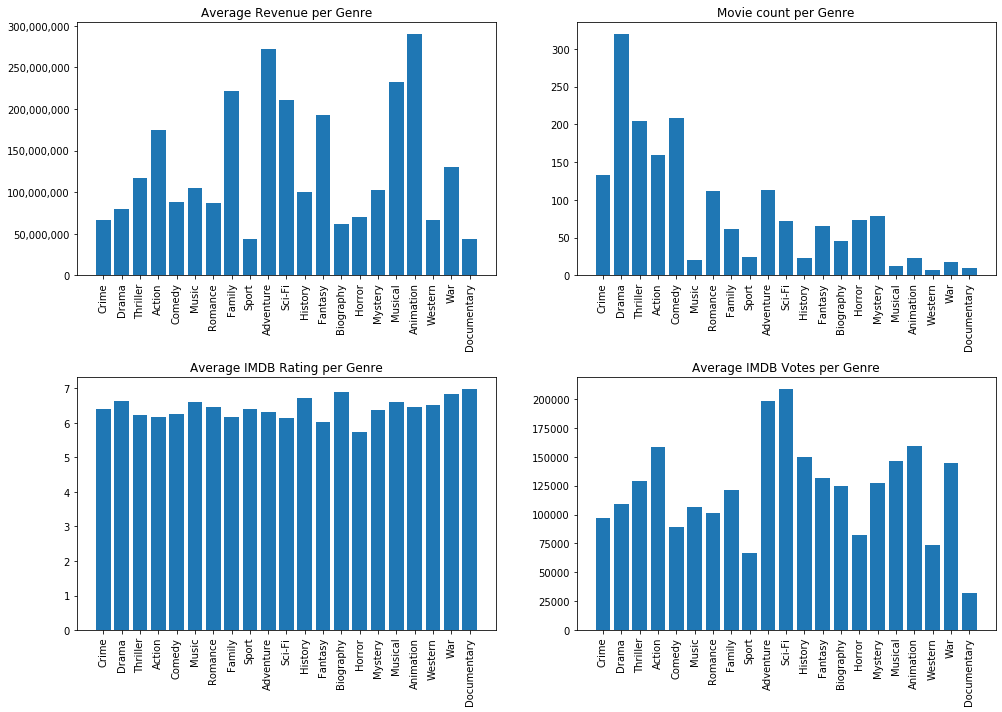

In [11]:
# set the length of the x-axis based on the number of genres in the genre list
x_pos = np.arange(len(genre_list))

# set the figure size and the subplot setup
fig = plt.figure(figsize=[20, 10])
gs = plt.GridSpec(2, 3, figure=fig)

# Create subplot & bar for the first graph
ax1 = fig.add_subplot(gs[0, 1])
ax1.bar(x_pos, height) 
# Create names on the x-axis
ax1.set_xticks(x_pos)
ax1.set_xticklabels(genre_list, rotation='vertical')
# Set the chart title
ax1.set_title('Average Revenue per Genre')
# Make sure the y-axis labels are not in scientific notation
ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Create subplot & bar for the second graph
ax2 = fig.add_subplot(gs[0, 2])
ax2.bar(x_pos, wedge)
# Create names on the x-axis
ax2.set_xticks(x_pos)
ax2.set_xticklabels(genre_list, rotation='vertical')
# Set the chart title
ax2.set_title('Movie count per Genre')

# Create subplot & bar for the third graph
ax3 = fig.add_subplot(gs[1, 1])
ax3.bar(x_pos, rating)
# Create names on the x-axis
ax3.set_xticks(x_pos)
ax3.set_xticklabels(genre_list, rotation='vertical')
# Set the chart title
ax3.set_title('Average IMDB Rating per Genre')

# Create subplot & bar for the fourth graph
ax4 = fig.add_subplot(gs[1, 2])
ax4.bar(x_pos, votes)
# Create names on the x-axis
ax4.set_xticks(x_pos)
ax4.set_xticklabels(genre_list, rotation='vertical')
# Set the chart title
ax4.set_title('Average IMDB Votes per Genre')

fig.tight_layout()
# Save the figure to a file, then show the graphic
bar_fig_path = os.path.join('figures','Bar_Genre.png')
fig.savefig(bar_fig_path)
plt.show()


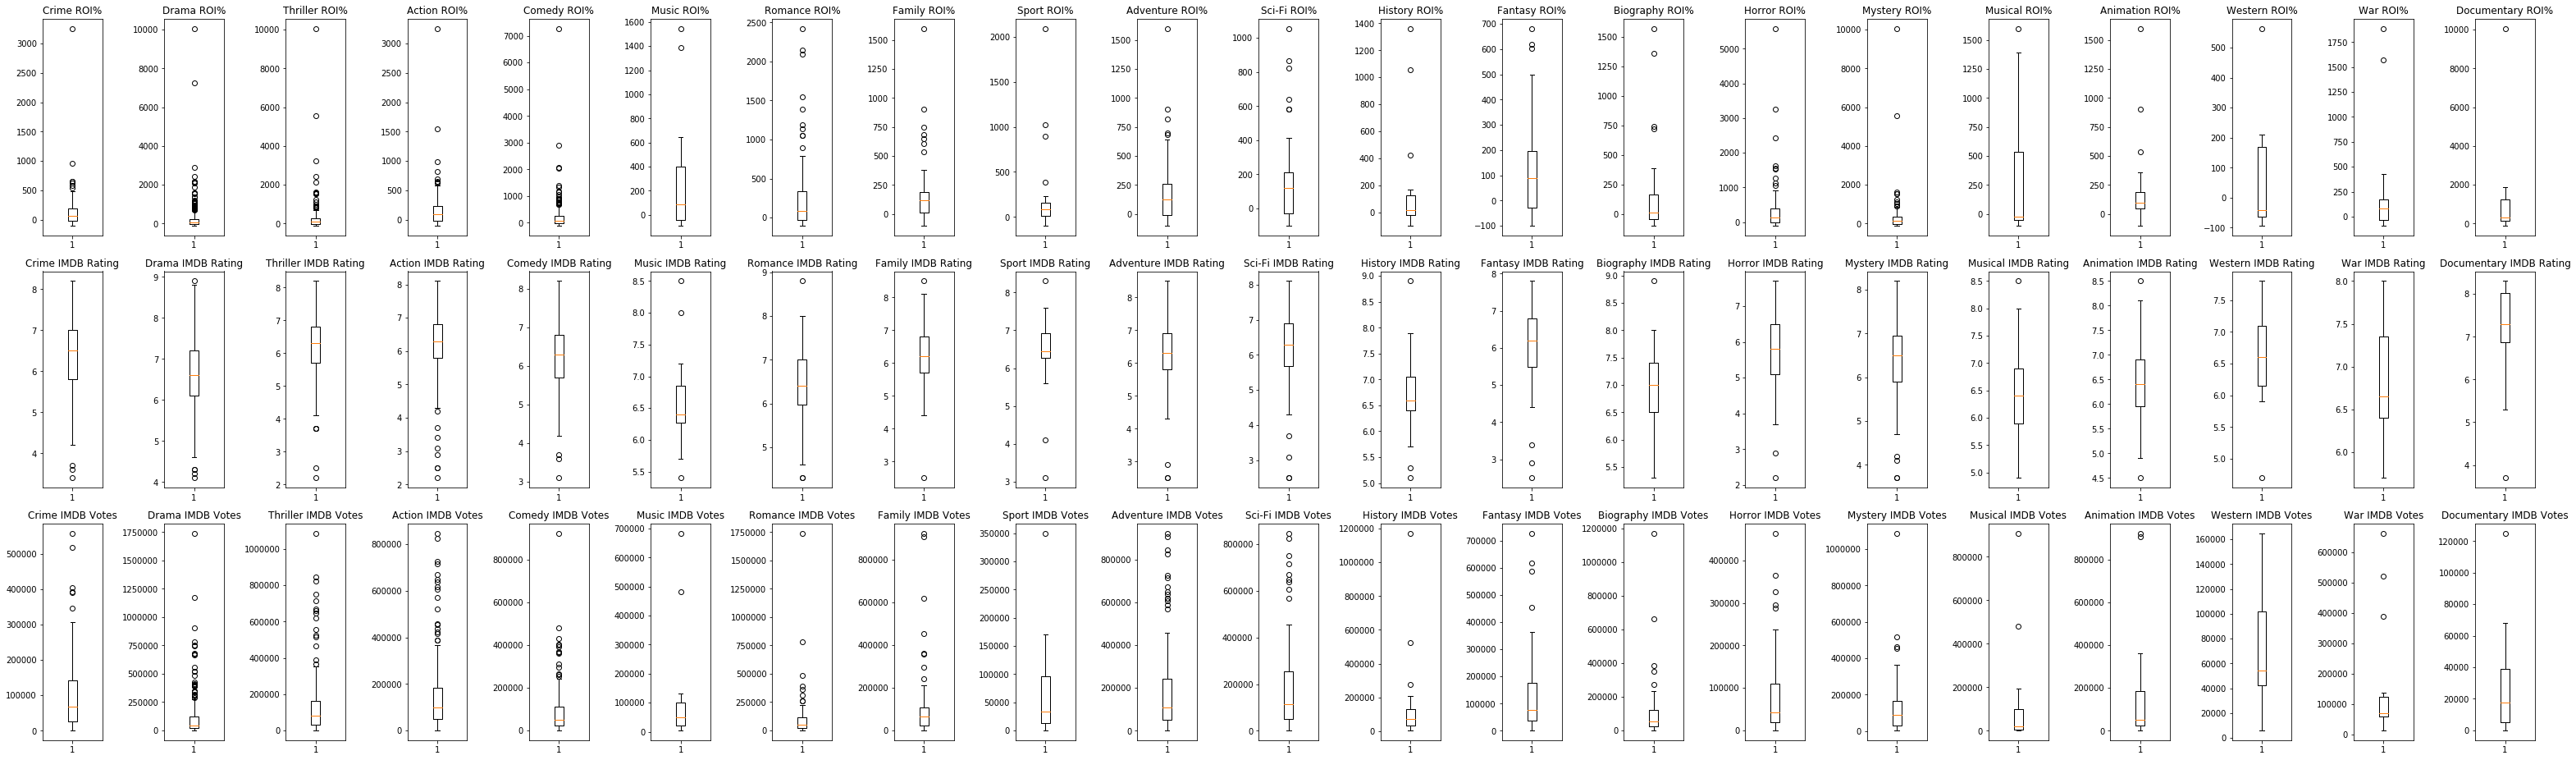

In [12]:
# set the figure size and the subplot setup
fig = plt.figure(figsize=[45, 17])
gs = plt.GridSpec(4, 22, figure=fig)

# initialize the variable to indicates the position of the plot in the subplot configuration
r = 1

# Loop through the different genres
for key in dictOfGenres:
    # Create a filtered ROI boxplot for the current genre
    ax1 = fig.add_subplot(gs[0, r])
    ax1.boxplot(dictOfGenres[key]['filt_ROI'])
    ax1.set_title(f'{key} ROI%')

    # Create a filtered IMDB Rating boxplot for the current genre
    ax2 = fig.add_subplot(gs[1, r])
    ax2.boxplot(dictOfGenres[key]['filt_Rating'])
    ax2.set_title(f'{key} IMDB Rating')

    # Create a filtered IMDB Votes boxplot for the current genre
    ax3 = fig.add_subplot(gs[2, r])
    ax3.boxplot(dictOfGenres[key]['filt_Votes'])
    ax3.set_title(f'{key} IMDB Votes')
    
    r+=1

fig.tight_layout()

# Save the figure to a file
box_fig_path = os.path.join('figures','Genre_all_separate_plots.png')
fig.savefig(box_fig_path)

# Show graphic
plt.show()

# All Genre Boxplots together in single y-axis

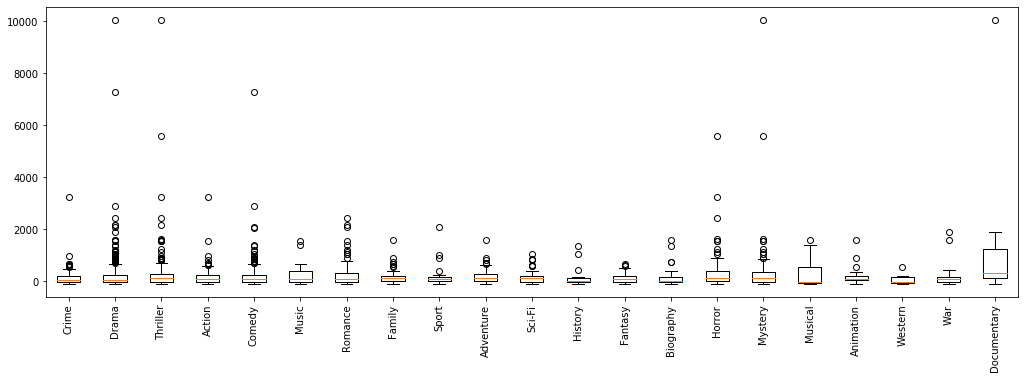

In [14]:
# set the figure size and the subplot setup
fig = plt.figure(figsize=[28, 20])
gs = plt.GridSpec(4, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 1])
ax1.boxplot([dictOfGenres['Crime']['filt_ROI'],dictOfGenres['Drama']['filt_ROI'],dictOfGenres['Thriller']['filt_ROI'],
            dictOfGenres['Action']['filt_ROI'],dictOfGenres['Comedy']['filt_ROI'],dictOfGenres['Music']['filt_ROI'],
            dictOfGenres['Romance']['filt_ROI'],dictOfGenres['Family']['filt_ROI'],dictOfGenres['Sport']['filt_ROI'],
            dictOfGenres['Adventure']['filt_ROI'],dictOfGenres['Sci-Fi']['filt_ROI'],dictOfGenres['History']['filt_ROI'],
            dictOfGenres['Fantasy']['filt_ROI'],dictOfGenres['Biography']['filt_ROI'],dictOfGenres['Horror']['filt_ROI'],
            dictOfGenres['Mystery']['filt_ROI'],dictOfGenres['Musical']['filt_ROI'],dictOfGenres['Animation']['filt_ROI'],
            dictOfGenres['Western']['filt_ROI'],dictOfGenres['War']['filt_ROI'],dictOfGenres['Documentary']['filt_ROI']])
ax1.set_xticklabels(genre_list, rotation='vertical')

fig.tight_layout()

# Save the figure to a file
box_fig_path = os.path.join('figures','Genre_ROI_all_together.png')
fig.savefig(box_fig_path)

# Show graphic
plt.show()

# All Genre Boxplots together in single y-axis (with upper y-limit)
the y-limit is set at the beginning of the notebook

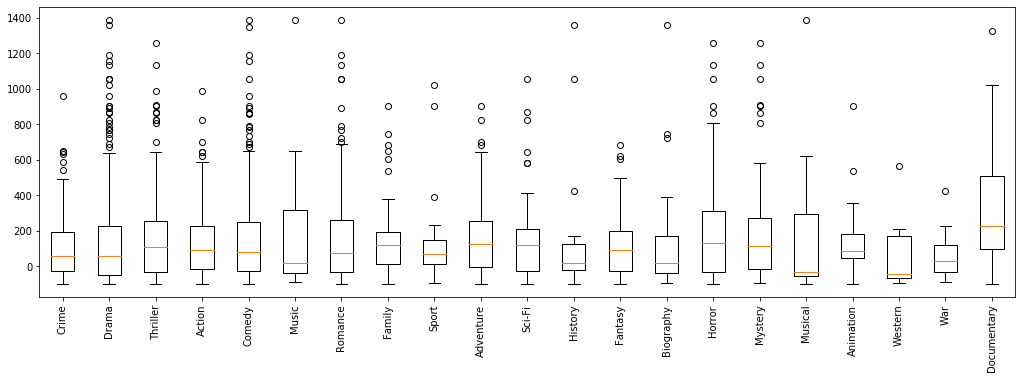

In [15]:
# set the figure size and the subplot setup
fig = plt.figure(figsize=[28, 20])
gs = plt.GridSpec(4, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 1])
ax1.boxplot([dictOfGenres['Crime']['filt_ROI_woOut'],dictOfGenres['Drama']['filt_ROI_woOut'],dictOfGenres['Thriller']['filt_ROI_woOut'],
            dictOfGenres['Action']['filt_ROI_woOut'],dictOfGenres['Comedy']['filt_ROI_woOut'],dictOfGenres['Music']['filt_ROI_woOut'],
            dictOfGenres['Romance']['filt_ROI_woOut'],dictOfGenres['Family']['filt_ROI_woOut'],dictOfGenres['Sport']['filt_ROI_woOut'],
            dictOfGenres['Adventure']['filt_ROI_woOut'],dictOfGenres['Sci-Fi']['filt_ROI_woOut'],dictOfGenres['History']['filt_ROI_woOut'],
            dictOfGenres['Fantasy']['filt_ROI_woOut'],dictOfGenres['Biography']['filt_ROI_woOut'],dictOfGenres['Horror']['filt_ROI_woOut'],
            dictOfGenres['Mystery']['filt_ROI_woOut'],dictOfGenres['Musical']['filt_ROI_woOut'],dictOfGenres['Animation']['filt_ROI_woOut'],
            dictOfGenres['Western']['filt_ROI_woOut'],dictOfGenres['War']['filt_ROI_woOut'],dictOfGenres['Documentary']['filt_ROI_woOut']])
ax1.set_xticklabels(genre_list, rotation='vertical')

fig.tight_layout()

# Save the figure to a file
box_fig_path = os.path.join('figures',f'full_figure_ROI_under{limit}.png')
fig.savefig(box_fig_path)

# Show graphic
plt.show()

### Histogram Plots
Original source code from: https://python-graph-gallery.com/24-histogram-with-a-boxplot-on-top-seaborn/ & https://python-graph-gallery.com/25-histogram-with-several-variables-seaborn/

Individual histograms for the four genres that had the smallest box in the boxplots.  The small boxes indicate that the values for these genres were the most consistent

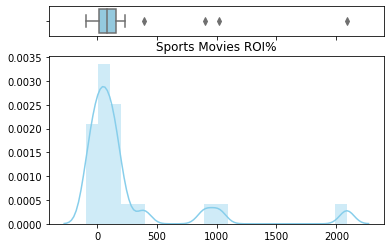

In [16]:
# Import library and dataset
import seaborn as sns
# import matplotlib.pyplot as plt
# df = sns.load_dataset('iris')
 
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

plt.title('Sports Movies ROI%')
# Add a graph in each part
sns.boxplot(dictOfGenres['Sport']['filt_ROI'], ax=ax_box, color="skyblue")
sns.distplot(dictOfGenres['Sport']['filt_ROI'], ax=ax_hist, color="skyblue")

 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

# Save the figure to a file
box_fig_path = os.path.join('figures',f'Histogram_Box_Sports_ROI.png')
plt.savefig(box_fig_path)

# Show graphic
plt.show()

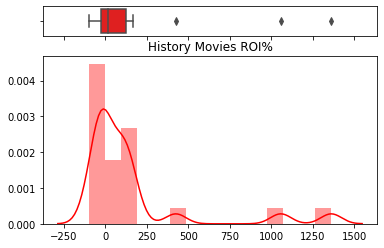

In [17]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

plt.title('History Movies ROI%')
# Add a graph in each part
sns.boxplot(dictOfGenres['History']['filt_ROI'], ax=ax_box, color="red")
sns.distplot(dictOfGenres['History']['filt_ROI'], ax=ax_hist, color="red")

 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

# Save the figure to a file
box_fig_path = os.path.join('figures',f'Histogram_Box_History_ROI.png')
plt.savefig(box_fig_path)

# Show graphic
plt.show()

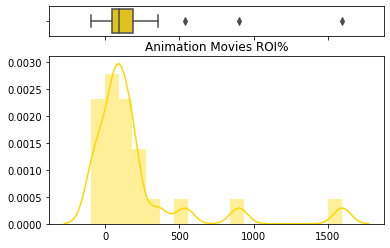

In [18]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

plt.title('Animation Movies ROI%')
# Add a graph in each part
sns.boxplot(dictOfGenres['Animation']['filt_ROI'], ax=ax_box, color="gold")
sns.distplot(dictOfGenres['Animation']['filt_ROI'], ax=ax_hist, color="gold")

# Remove x axis name for the boxplot
ax_box.set(xlabel='')

# Save the figure to a file
box_fig_path = os.path.join('figures',f'Histogram_Box_Animation_ROI.png')
plt.savefig(box_fig_path)

# Show graphic
plt.show()

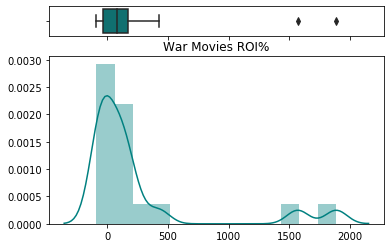

In [19]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

plt.title('War Movies ROI%')
# Add a graph in each part
sns.boxplot(dictOfGenres['War']['filt_ROI'], color="teal", ax=ax_box)
sns.distplot(dictOfGenres['War']['filt_ROI'], color="teal", ax=ax_hist)

# Remove x axis name for the boxplot
ax_box.set(xlabel='')

# Save the figure to a file
box_fig_path = os.path.join('figures',f'Histogram_Box_War_ROI.png')
plt.savefig(box_fig_path)

# Show graphic
plt.show()

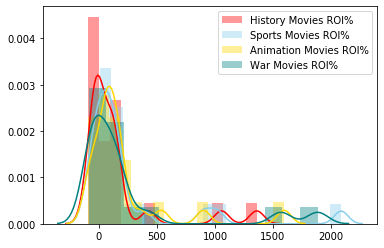

In [20]:
# Import library and dataset
import seaborn as sns

# Method 1: on the same Axis
sns.distplot( dictOfGenres['History']['filt_ROI'] , color="red", label="History Movies ROI%")
sns.distplot( dictOfGenres['Sport']['filt_ROI'] , color="skyblue", label="Sports Movies ROI%")
sns.distplot( dictOfGenres['Animation']['filt_ROI'] , color="gold", label="Animation Movies ROI%")
sns.distplot( dictOfGenres['War']['filt_ROI'] , color="teal", label="War Movies ROI%")
plt.legend()

# Save the figure to a file
box_fig_path = os.path.join('figures',f'Histogram_AllFour_Filt_ROI.png')
plt.savefig(box_fig_path)

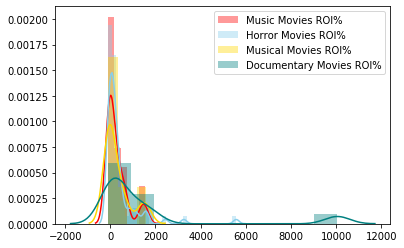

In [21]:
# Import library and dataset
import seaborn as sns

# Method 1: on the same Axis
sns.distplot( dictOfGenres['Music']['filt_ROI'] , color="red", label="Music Movies ROI%")
sns.distplot( dictOfGenres['Horror']['filt_ROI'] , color="skyblue", label="Horror Movies ROI%")
sns.distplot( dictOfGenres['Musical']['filt_ROI'] , color="gold", label="Musical Movies ROI%")
sns.distplot( dictOfGenres['Documentary']['filt_ROI'] , color="teal", label="Documentary Movies ROI%")
plt.legend()
 
# Save the figure to a file
box_fig_path = os.path.join('figures',f'Histogram_AllFour_NoFilt_ROI.png')
plt.savefig(box_fig_path)